In [1]:
from __future__ import absolute_import
from __future__ import print_function
import os
import glob
import random
import numpy as np
from keras import optimizers
from keras.layers import LSTM
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.layers.wrappers import TimeDistributed
from keras.applications.mobilenet import MobileNet
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.layers import Input
from keras.layers.core import Activation, Flatten, Reshape
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.applications import imagenet_utils

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
height = 120
width = 240
path = '../datasets/'
allfiles = glob.glob(path+'sensory/tile/*.npy')
sali = glob.glob(path+'content/saliencyImages/*.npy')
motion = glob.glob(path+'content/motionImages/*.npy')
prob = glob.glob(path+'sensory/tileProb/*.npy')

def myGenerator():
    while True:
        index_list = random.sample(range(1, 23999), 3)
        alldata_x = []
        alldata_y = []
        for i in index_list:
            f = allfiles[i]
            s = f.split('_')
            saliFile = '../datasets/content/saliencyImages/'+s[0][25:]+'_saliency_'+s[2].split('.')[0]+'.npy'
            motionFile = '../datasets/content/motionImages/'+s[0][25:]+'_motion_'+s[2].split('.')[0]+'.npy'
            probFile = '../datasets/sensory/tileProb/'+s[0][25:]+'_user'+s[1][4:]+'_'+s[2].split('.')[0]+'.npy'
            a = np.load(f)
            b = np.load(saliFile)
            c = np.load(motionFile)
            d = [a, b, c]
            alldata_x.append(d)
            alldata_y.append(np.load(probFile))
        alldata_x = np.array(alldata_x)
        alldata_x = np.rollaxis(alldata_x, 1, 5)  
        #alldata_x = alldata_x.reshape((32, 30, height, width, 3))
        #alldata_x = np.swapaxes(alldata_x, 1, 4)
        alldata_y = np.array(alldata_y)
        yield alldata_x, alldata_y
# x = myGenerator()
# xtrain, ytrain = next(x)
# print('xtrain shape:',xtrain.shape)
# print('ytrain shape:',ytrain.shape)

In [3]:
# load the numpy arrays from saliency, motion maps and sensor data
sali = glob.glob(path+'content/saliencyImages/*.npy')
motion = glob.glob(path+'content/motionImages/*.npy')
sensory = glob.glob(path+'sensory/tile/*.npy')
input_shape=(30, height, width, 3)

In [7]:
def mySegNet(input_shape):
    base_model  = MobileNet(input_shape=(224,224,3), include_top=False)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    cnn_model = Model(inputs=base_model.input, outputs=x)
    
    model = Sequential();
    model.add(TimeDistributed(cnn_model, input_shape=input_shape))
    model.add(TimeDistributed(Flatten()))
    
    model.add(LSTM(200, return_sequences=True))
    model.compile(optimizer='adam', loss='mean_squared_error')
    #print(model.summary())
    return model 

In [ ]:
input_shape=(30, height, width, 3)
model = mySegNet(input_shape)

model.fit_generator(generator=myGenerator(),
                    use_multiprocessing=True,
                   steps_per_epoch=300, epochs=100)
model.save('model1.h5')
model.save_weights('model_weights1.h5')


In [11]:
input_shape=(30, height, width, 3)
model = mySegNet(input_shape)
model.load_weights('model_weights2.h5')
totalTestSamples = len(allfiles)
predictions = []
ytrue = []
for i in range(0, totalTestSamples, batchSize):
    x = myTestDataGenerator()
    xtest, ytest = next(x)
    ytrue.append(ytest)
    pred = model.predict(xtest, batch_size=batchSize)
    for p in pred:
        predictions.append(p)
print('predictions shape: ', np.array(predictions).shape)

predictions shape:  (6000, 30, 200)


In [60]:
tileFrames = []
for sample in ytrue[:1]:
    for frames in sample:
        t = []
        for frame in frames:
            f = []
            for i, j in enumerate(frame):
                if j!=0:
                    f.append(i+1)
            tileFrames.append(f)
print(np.array(tileFrames).shape)

(90,)


In [59]:
pTileFrames = []
for sample in predictions[:3]:
    for frames in sample:
        f = []
        for i, j in enumerate(frames):
            if j!=0:
                f.append(i+1)
        pTileFrames.append(f)
print(np.array(pTileFrames).shape)

(90,)


[67, 68, 69, 70, 86, 87, 88, 89, 90, 91, 106, 107, 108, 109, 110, 111, 126, 127, 128, 129, 130, 131, 146, 147, 148, 149, 150, 151, 167, 168, 169, 170]


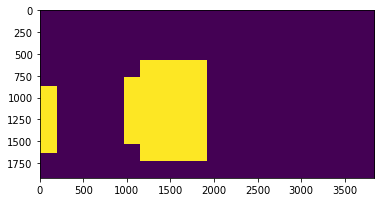

In [82]:
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

breadth = 3840
width = 1920
tileSize = 192
tilesInColumn = width / tileSize
for i, tiles in enumerate(tileFrames):
    frame = np.zeros(width*breadth)
    print(tiles)
    for tileNo in tiles:
        tileRowNumber = int((tileNo - 1) / tilesInColumn)
        tileColumnNumber = (tileNo - 1) % tilesInColumn
        firstPixel = tileRowNumber * width * tileSize + tileColumnNumber * tileSize
        for rowPixel in range(0, tileSize):
            for columnPixel in range(0, tileSize):
                frame[int(firstPixel + rowPixel * breadth + columnPixel)] = 255
    frame = frame.reshape((width, breadth))
    plt.imshow(frame, interpolation='nearest')
    plt.show()
    break

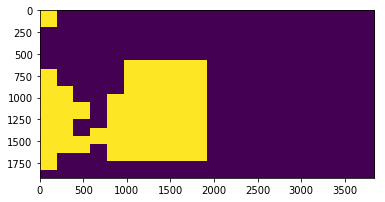

In [83]:
for i, tiles in enumerate(pTileFrames):
    frame = np.zeros(width*breadth)
    for tileNo in tiles:
        tileRowNumber = int((tileNo - 1) / tilesInColumn)
        tileColumnNumber = (tileNo - 1) % tilesInColumn
        firstPixel = tileRowNumber * width * tileSize + tileColumnNumber * tileSize
        for rowPixel in range(0, tileSize):
            for columnPixel in range(0, tileSize):
                frame[int(firstPixel + rowPixel * breadth + columnPixel)] = 255
    frame = frame.reshape((width, breadth))
    plt.imshow(frame, interpolation='nearest')
    plt.show()
    break

In [ ]:
index  = 28
thresh = 0.5

temp = predictions[0][index] 
temp[temp > thresh] = 1
temp[temp <= thresh] = 0

for i, j in enumerate(ytest[0][index]):
    if ytest[0][index][i] != temp[i]:
        print('Index: ', i, 'Value: ', ytest[0][index][i], temp[i])

In [ ]:
print(ytest[0][index].shape)